In [1]:
# prompt: how to import dataset from google drive

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd

# Replace 'path/to/your/file.csv' with the actual path to your file in Google Drive
dataset_dir = '/content/drive/MyDrive/GuavaDiseaseDataset/GuavaDiseaseDataset'

In [18]:
train_dir=dataset_dir+'/train'
test_dir=dataset_dir+'/test'
val_dir=dataset_dir+'/val'

In [19]:
df=pd.read_csv("/content/drive/MyDrive/GuavaDiseaseDataset/dataset_summary.csv")
df.head()

,data_split,sub_directory,image_count
0,val,healthy_guava,185
1,val,fruit_fly,262
2,val,Anthracnose,308
3,test,healthy_guava,94
4,test,fruit_fly,132


In [20]:
df.value_counts()

data_split  sub_directory  image_count
test        Anthracnose    156            1
            fruit_fly      132            1
            healthy_guava  94             1
train       Anthracnose    1080           1
            fruit_fly      918            1
            healthy_guava  649            1
val         Anthracnose    308            1
            fruit_fly      262            1
            healthy_guava  185            1
Name: count, dtype: int64

LOAD IMAGE

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

In [16]:
train_data=image_dataset_from_directory(train_dir,batch_size=32,image_size=(224,224))
test_data=image_dataset_from_directory(test_dir,batch_size=32,image_size=(224,224))
val_data=image_dataset_from_directory(val_dir,batch_size=32,image_size=(224,224))

Found 2647 files belonging to 3 classes.
Found 382 files belonging to 3 classes.
Found 755 files belonging to 3 classes.


VISUALIZE DATA

Class Names: ['Anthracnose', 'fruit_fly', 'healthy_guava']


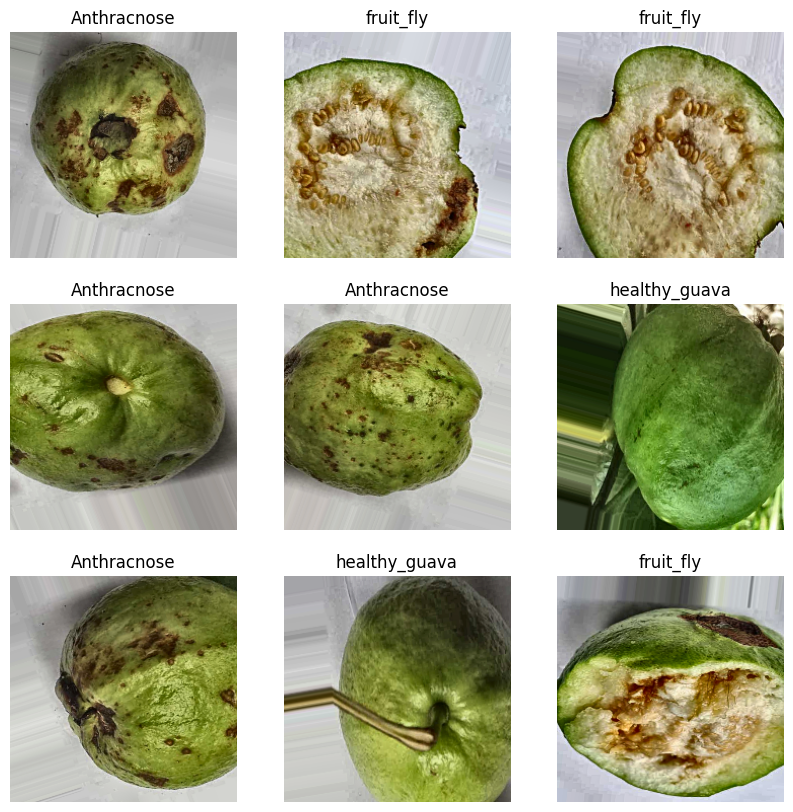

In [22]:
import matplotlib.pyplot as plt

class_names = train_data.class_names
print("Class Names:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

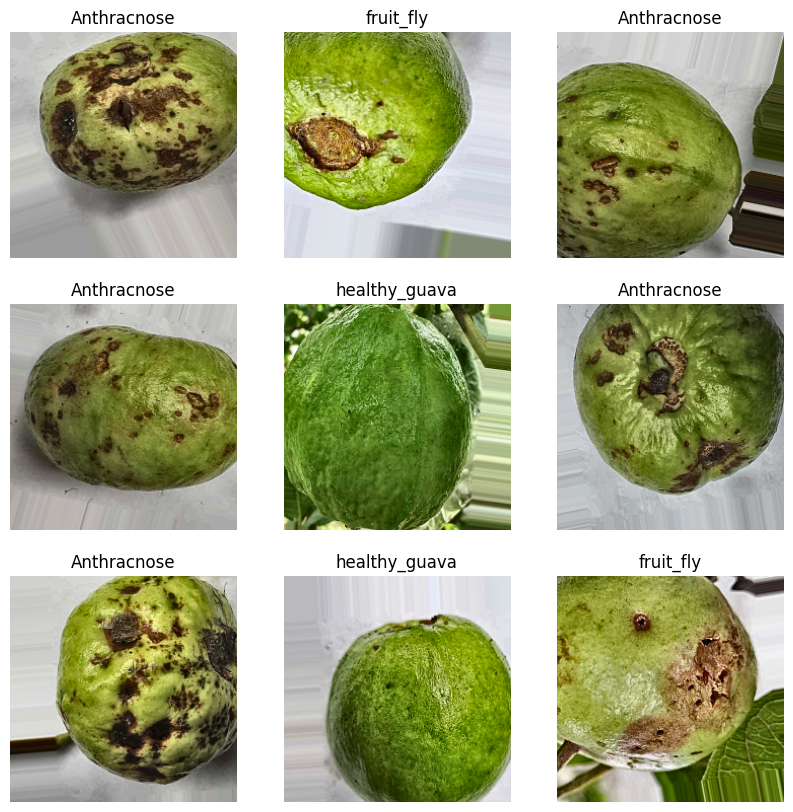

In [23]:
class_names = val_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in val_data.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

PREPROCESSING

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import Sequential

In [25]:
# Data Augmentation to prevent overfitting
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Preprocess the data: Scale pixel values (0-255) to range [0, 1]
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (Rescaling(1./255)(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

train_data = preprocess_dataset(train_data.map(lambda x, y: (data_augmentation(x), y)))
val_data = preprocess_dataset(val_data)
test_data = preprocess_dataset(test_data)


MODEL BUILDING

In [26]:
from tensorflow.keras import layers, models

# Build a CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')  # 3 classes for classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 465s 6s/step - accuracy: 0.5291 - loss: 1.1782 - val_accuracy: 0.7735 - val_loss: 0.4900
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.7744 - loss: 0.5703 - val_accuracy: 0.8702 - val_loss: 0.3360
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.8538 - loss: 0.3842 - val_accuracy: 0.8821 - val_loss: 0.2665
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.8728 - loss: 0.3343 - val_accuracy: 0.7430 - val_loss: 1.0310
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.8919 - loss: 0.2974 - val_accuracy: 0.9046 - val_loss: 0.2353
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.9250 - loss: 0.2121 - val_accuracy: 0.8901 - val_loss: 0.3224
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.9525 - loss: 0.1346 - val_accuracy: 0.7934 - val_loss: 0.7979
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.9587 - loss: 0.1114 - val_accuracy: 0.8503 - v

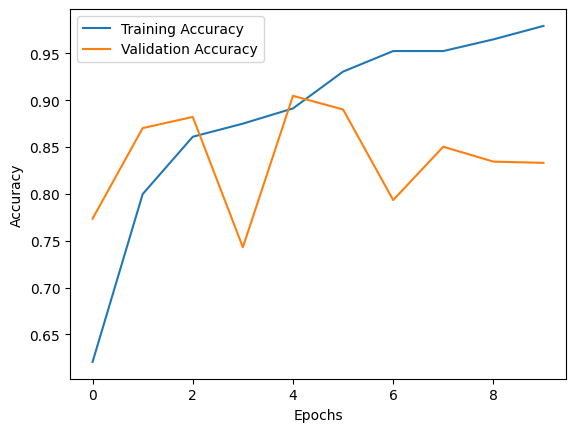

In [28]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Start with 10 epochs and adjust based on performance
)


def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


EVALUATION

12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8425 - loss: 1.0359
Test Accuracy: 85.34%
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


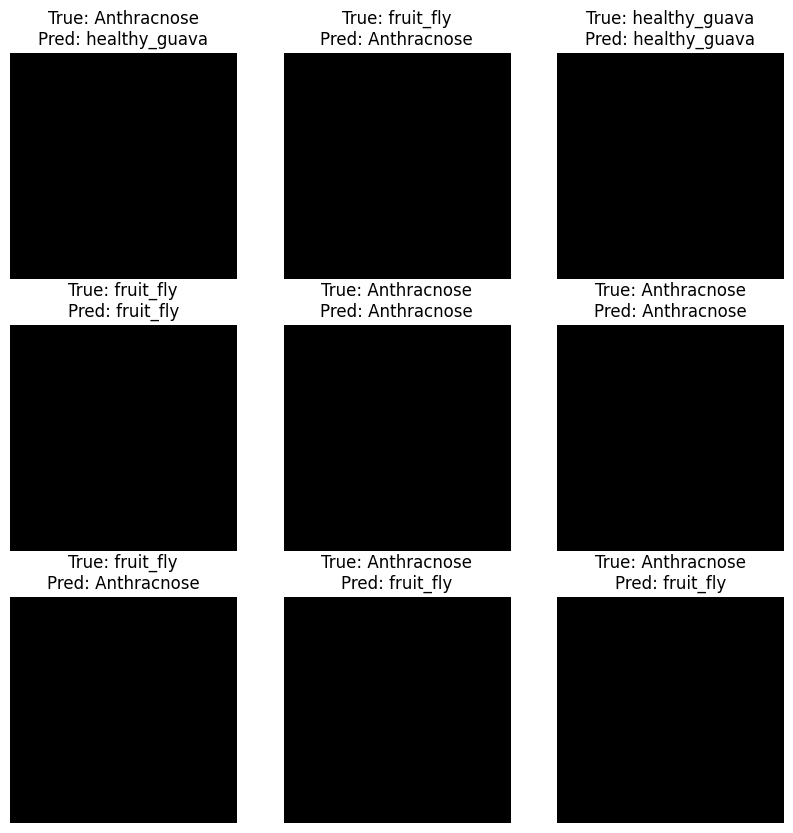

In [29]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_data)

# Visualize a few predictions
import numpy as np

for images, labels in test_data.take(1):  # Take one batch from the test dataset
    predicted_labels = np.argmax(predictions, axis=1)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()


MOBILENET

In [30]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust for 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7233 - loss: 0.6990 - val_accuracy: 0.9563 - val_loss: 0.1288
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9495 - loss: 0.1531 - val_accuracy: 0.9709 - val_loss: 0.0942
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9608 - loss: 0.1165 - val_accuracy: 0.9563 - val_loss: 0.0947
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9681 - loss: 0.0888 - val_accuracy: 0.9775 - val_loss: 0.0581
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9823 - loss: 0.0693 - val_accuracy: 0.9801 - val_loss: 0.0550
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9856 - loss: 0.0486 - val_accuracy: 0.9828 - val_loss: 0.0496
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9891 - loss: 0.0408 - val_accuracy: 0.9735 - val_loss: 0.0535
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9900 - loss: 0.0352 - val_accuracy: 0.9841 - v

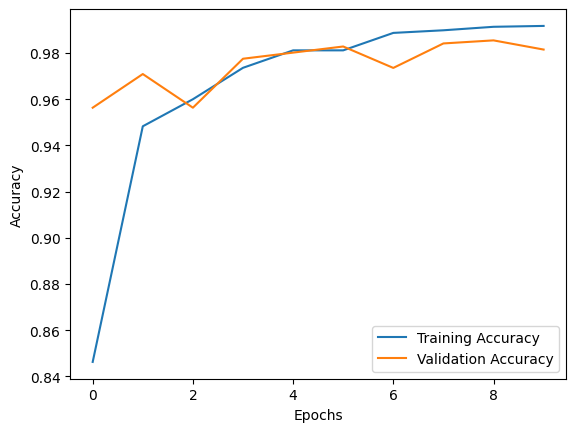

In [31]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Start with 10 epochs and adjust based on performance
)


def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9915 - loss: 0.0420
Test Accuracy: 98.17%
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


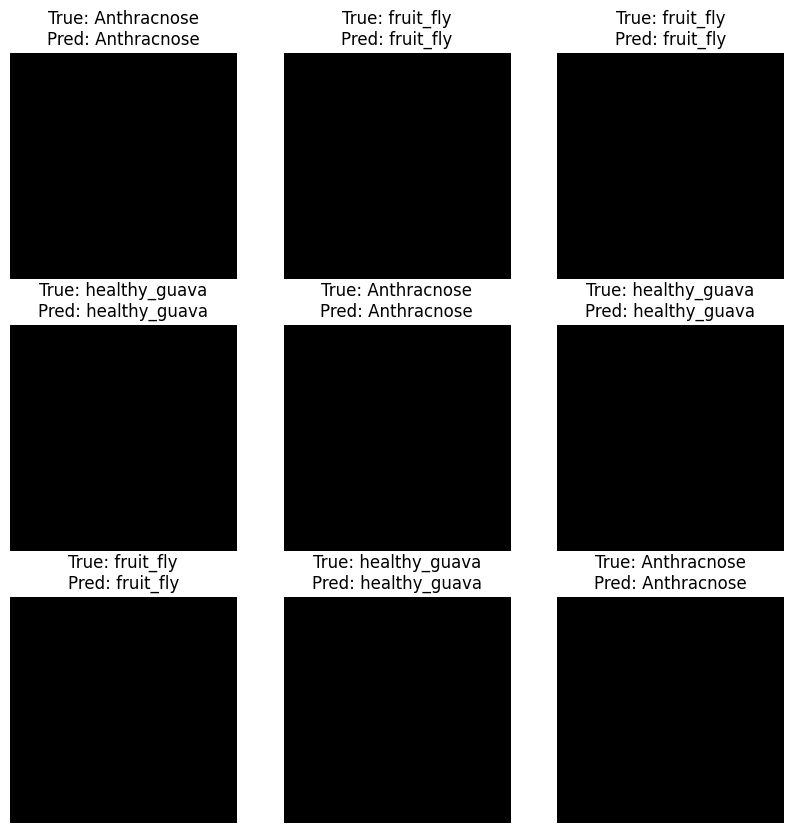

In [32]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_data)

# Visualize a few predictions
import numpy as np

for images, labels in test_data.take(1):  # Take one batch from the test dataset
    predicted_labels = np.argmax(predictions, axis=1)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()
